In [66]:
Nn = 3
Ns = 40
N = 4
PBC = 1  # 0 or 1
source = 'DMRG' #'ED' or 'DMRG'
Λ = 10000
ω = 0
maxOcc = 3
g = '2.000000' #or 'infty'
gdd = '-1.000000' #or 'none'
sigma = 0.025 #or 'none'
maxRange=8
corrsType='normalised' # 'raw' or 'normalised'

In [67]:
import time

print("Importing libraries...",end='')
t0 = time.time()

import numpy as np
from scipy.sparse import csr_matrix, lil_matrix
from scipy.sparse.linalg import eigsh
from scipy.linalg import ishermitian
from numpy import sqrt,exp,pi,zeros,arange,copy, sin, pi,loadtxt,poly1d, ones,reshape,floor,linspace

from numpy import linalg as LA
import matplotlib.pyplot as plt
import scipy

D = 1/Ns

print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))

Importing libraries...DONE in 0.201 [ms]


In [68]:
print("Loading corrs list...",end='')
t0 = time.time()

Corrs1 = {}
if gdd == 'none':
    data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
else:
    data = loadtxt('./Corrs1/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%s_gdd%s_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,maxOcc,source))

for row in data:
    Corrs1[tuple([int(x) for x in row[0:-1]])] = float(row[-1])
    
Corrs2 = {}
if gdd == 'none':
    data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.2f_g%s_maxRange%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,maxRange,source))
else:
    data = loadtxt('./Corrs2/N%i_Ns%i_Nn%i_PBC%i_Lambda%.2f_omega%.6f_g%s_gdd%s_sigma%.6f_maxRange%i_maxOcc%i_%s'%(N,Ns,Nn,PBC,Λ,ω,g,gdd,sigma,maxRange,maxOcc,source))

for row in data:
    Corrs2[tuple([int(x) for x in row[0:-1]])] = float(row[-1])

print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))


def getG2cutRef(N,g,gdd,sigma,pMax,m):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,1]

def getXscutRef(N,g,gdd,sigma,pMax=50,m=250):
    pTot=0
    nEig=1
    dataW = np.loadtxt("./program_wojtka-main/data/cov_n%i_pmax%i_ptot%i_neig%i_m%i_g%.6f_gdd%.6f_sigma%.6f.txt"%(N,pMax,pTot,nEig,m,float(g),abs(float(gdd)),sigma))
    return dataW[:,0]

Loading corrs list...DONE in 176.589 [ms]


In [69]:
def fg(j,n,x):
    if n==0:
        return 1/sqrt(D)
    if n==1:
        return sqrt(3/D)*(2*x/D-2*j-1)
    if n==2:
        return sqrt(5/4/D)*(3*(2*x/D-2*j-1)**2-1)
    print("ErrG")
    return 0

def rhoRef(x,t='hermit'):
    if t =='hermit':
        return N*sqrt(ω/pi)*exp(-ω*x**2)
    if t =='qwell':
        return N*2*sin(pi*(x+1/2))**2

def rho(x):
    j = floor(x/D)
   
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            out += fg(j,n,x)*fg(j,np,x)*Corrs1[j,n,j,np]
    return out

def G1(x,xp):
    j = floor(x/D)
    jp = floor(xp/D)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            out += fg(j,n,x)*fg(jp,np,xp)*Corrs1[j,n,jp,np]
    return out

def G2(x,xp):
    j = floor(x/D)
    jp = floor(xp/D)
    
    out = 0
    for n in range(Nn):
        for np in range(Nn):
            for npp in range(Nn):
                for nppp in range(Nn):
                    out += fg(j,n,x)*fg(jp,np,xp)*fg(jp,npp,xp)*fg(j,nppp,x)*Corrs2[j,jp,n,np,npp,nppp]
    return out
    
    

print("Computing Correlations...",end='')
t0 = time.time()

#xs = arange(-0.5,0.5,1/99)
xs = linspace(-0.5,0.49999,101)

G1s = zeros((len(xs),len(xs)),dtype=float)
G2s = zeros((len(xs),len(xs)),dtype=float)

g1s = ones((len(xs),len(xs)),dtype=float)
g2s = ones((len(xs),len(xs)),dtype=float)

for ix in range(len(xs)):
    for ixp in range(len(xs)):
        G1s[ix,ixp] = G1(xs[ix],xs[ixp])
        G2s[ix,ixp] = G2(xs[ix],xs[ixp])
        
for ix in range(len(xs)):
    for ixp in range(len(xs)):        
        if (G1s[ix,ix]>1e-4) and (G1s[ixp,ixp]>1e-4):
            g1s[ix,ixp] = G1s[ix,ixp]/sqrt(G1s[ix,ix]*G1s[ixp,ixp])
            g2s[ix,ixp] = G2s[ix,ixp]/G1s[ix,ix]/G1s[ixp,ixp]
        else:
            g1s[ix,ixp] = np.nan
            g2s[ix,ixp] = np.nan


rhos = []
rhosQWell = []

for x in xs:
    rhos.append( rho(x) )
    rhosQWell.append( rhoRef(x,t='qwell') )
        
print("DONE in %0.3f [ms]"%(1000*(time.time()-t0)))  

Computing Correlations...DONE in 2073.221 [ms]


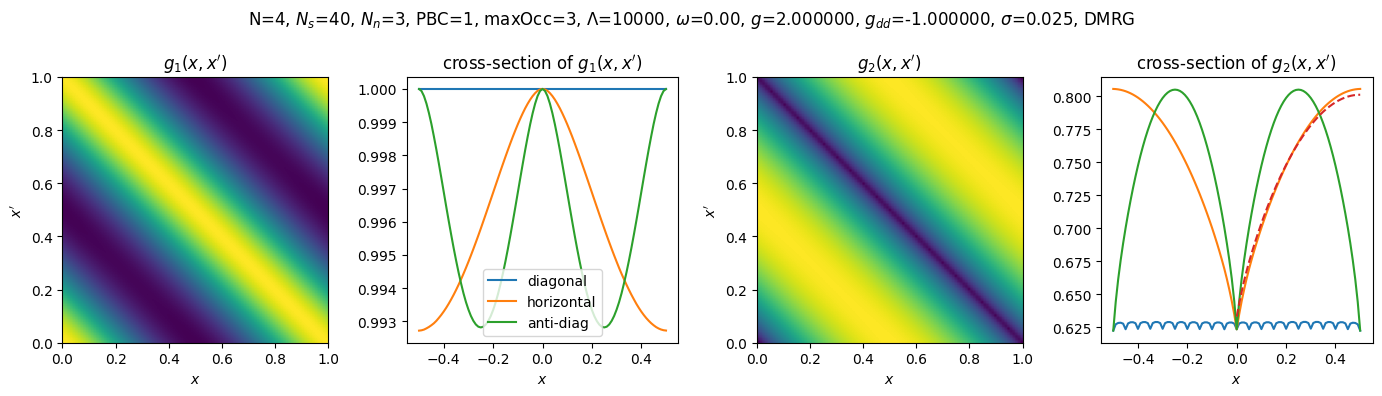

In [71]:
fig, ax = plt.subplots(1,4,figsize=[14,4])

fig.suptitle('N=%i, $N_s$=%i, $N_{n}$=%i, PBC=%i, maxOcc=%i, $\Lambda$=%i, $\omega$=%.2f, $g$=%s, $g_{dd}$=%s, $\sigma$=%s, %s'%(N,Ns,Nn,PBC,maxOcc,Λ,ω,g,gdd,sigma,source))

if corrsType=='raw':
    G1Map = G1s
    G2Map = G2s
    ax[0].set_title("$G_1(x,x')$")
    ax[1].set_title("cross-section of $G_1(x,x')$")
    ax[2].set_title("$G_2(x,x')$")
    ax[3].set_title("cross-section of $G_2(x,x')$")

    
elif corrsType=='normalised':
    G1Map = g1s
    G2Map = g2s
    ax[0].set_title("$g_1(x,x')$")
    ax[1].set_title("cross-section of $g_1(x,x')$")
    ax[2].set_title("$g_2(x,x')$")
    ax[3].set_title("cross-section of $g_2(x,x')$")
    
    
    
cmap = ax[0].imshow(G1Map,extent =[0,1,0,1])
cmap = ax[2].imshow(G2Map,extent =[0,1,0,1])

ax[1].plot(xs,[G1Map[i,i] for i in range(len(xs))],label='diagonal')
ax[1].plot(xs,[G1Map[int(len(xs)/2),i] for i in range(len(xs))],label='horizontal')
ax[1].plot(xs,[G1Map[i,len(xs)-i-1] for i in range(len(xs))],label='anti-diag')

ax[3].plot(xs,[G2Map[i,i] for i in range(len(xs))])
ax[3].plot(xs,[G2Map[int(len(xs)/2),i] for i in range(len(xs))])
ax[3].plot(xs,[G2Map[i,len(xs)-i-1] for i in range(len(xs))])
ax[3].plot(getXscutRef(N,g,gdd,sigma,100,350),[x/N**2 for x in getG2cutRef(N,g,gdd,sigma,100,350)],'--')


if corrsType=='raw' and PBC==0:
    ax[1].plot(xs,rhosQWell,'--',label='ref,QWell')

#ax[0].cbar(cmap)
ax[0].set_xlabel('$x$')
ax[0].set_ylabel("$x'$")
ax[1].set_xlabel('$x$')
ax[2].set_xlabel('$x$')
ax[2].set_ylabel("$x'$")
ax[3].set_xlabel('$x$')
ax[1].legend()
plt.tight_layout()
plt.savefig('./figures/Correlations_N%i_Ns%i_Nn%i_maxOcc%i_PBC%i_Lambda%.2f_omega%.2f_g%s_%s.pdf'%(N,Ns,Nn,maxOcc,PBC,Λ,ω,g,source), dpi=300 )
plt.show()

In [ ]:
from numpy import linalg as LA

eigenvalues, eigenvectors = LA.eigh(G1s)
eigenvalues /= sqrt(sum(abs(eigenvalues)**2))
print(eigenvalues)

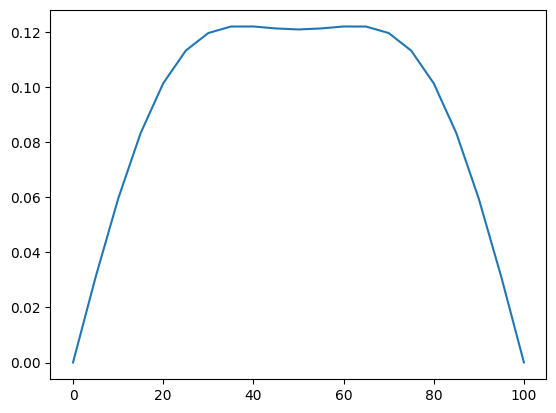

In [7]:
plt.plot(eigenvectors[:,-1])